In [1]:
# cloning the rgithub repository of fnc to get data in colab
!git clone https://github.com/veni-jindal/FakeNewsChallenge.git

Cloning into 'FakeNewsChallenge'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 4), reused 16 (delta 2), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [8]:
# importing required packages
import pandas as pd
import numpy as np
import os
from csv import DictReader
import re
import nltk
from sklearn import feature_extraction
nltk.download('wordnet')
nltk.download('punkt')
_wnl = nltk.WordNetLemmatizer()
from tqdm import tqdm

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, concatenate, dot, Dropout
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2

In [10]:
# reading the dataset from the fnc-1 data
class DataSet():
    def __init__(self, name, path="FakeNewsChallenge/fnc-1"):
        self.path = path

        print("Reading train dataset")
        bodies = name+"_bodies.csv"
        stances = name+"_stances.csv"
        print(stances)

        self.stances = self.read(stances)
        articles = self.read(bodies)
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])

        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))
    
    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows

In [11]:
'''Preprocessing steps used for cleaning the text'''
# getting the root word
def normalize_word(w):
    return _wnl.lemmatize(w).lower()

# tokenisation and lowering the text
def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]

# Cleans a string: Lowercasing, trimming, removing non-alphanumeric
def clean(s):  
    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()

# Removes stopwords from a list of tokens
def remove_stopwords(l):
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


In [12]:
# data preprocessing of headlines & bodies
def data_preprocessing(headlines, bodies):
    # clean_head, clean_body
    clean_h = []
    clean_b = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
    
      clean_headline = clean(headline)
      clean_body = clean(body)
      clean_headline = get_tokenized_lemmas(clean_headline)
      clean_body = get_tokenized_lemmas(clean_body)
      clean_headline = remove_stopwords(clean_headline)
      clean_body = remove_stopwords(clean_body)
      clean_h.append(' '.join(clean_headline))
      clean_b.append(' '.join(clean_body))
    
    return(clean_h, clean_b)
      

In [13]:
# getting train dataset
train = DataSet("train")
# getting test dataset
test = DataSet("competition_test")
# labels list
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
# labels - Related/Unrelated
LABELS_RELATED = ['unrelated','related']
# Getting the labels belonging to related category
RELATED = LABELS[0:3]

Reading train dataset
train_stances.csv
Total stances: 49972
Total bodies: 1683
Reading train dataset
competition_test_stances.csv
Total stances: 25413
Total bodies: 904


In [14]:
# headlines
h = []
h_test = []
# labels for stance
y = []
test_label = []
# body text
b = []
b_test = []
# getting data for training set
for s in train.stances:
  h.append(s['Headline'])
  b.append(train.articles[s['Body ID']])
  y.append(LABELS.index(s['Stance']))
# getting data for test set
for s in test.stances:
  h_test.append(s['Headline'])
  b_test.append(test.articles[s['Body ID']])
  test_label.append(LABELS.index(s['Stance']))

In [35]:
# loading glove pretrained model
# dictionary to store word vvectors
embeddings_index = dict()
f = open('glove.6B.100d.txt')
# loop over each line to get vector and word
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [36]:
# preparing word index dictionary
word_index = {w: i for i, w in enumerate(embeddings_index.keys(), 1)}
dims = 100
len(word_index)

400000

In [37]:
#create embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, dims))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:dims]


In [38]:
# converting texts to sequence using text_to_word_sequence keras
def texts_to_sequences(texts, word_index):
    for text in texts:
        tokens = text_to_word_sequence(text)
        return [word_index.get(w) for w in tokens if w in word_index]

In [18]:
'''GENERATING TRAIN VALIDATION SETS SPLIT SO THAT THE ARTICLE BODIES DON'T OVERLAP'''
# same as fnc-1 baseline
import random
import os
from collections import defaultdict


def generate_hold_out_split (dataset, training = 0.8, base_dir="splits"):
    r = random.Random()
    r.seed(1489215)

    article_ids = list(dataset.articles.keys())  # get a list of article ids
    r.shuffle(article_ids)  # and shuffle that list


    training_ids = article_ids[:int(training * len(article_ids))]
    hold_out_ids = article_ids[int(training * len(article_ids)):]

    # write the split body ids out to files for future use
    with open(base_dir+ "/"+ "training_ids.txt", "w+") as f:
        f.write("\n".join([str(id) for id in training_ids]))

    with open(base_dir+ "/"+ "hold_out_ids.txt", "w+") as f:
        f.write("\n".join([str(id) for id in hold_out_ids]))



def read_ids(file,base):
    ids = []
    with open(base+"/"+file,"r") as f:
        for line in f:
           ids.append(int(line))
        return ids


def kfold_split(dataset, training = 0.8, n_folds = 10, base_dir="./"):
    if not (os.path.exists(base_dir+ "/"+ "training_ids.txt")
            and os.path.exists(base_dir+ "/"+ "hold_out_ids.txt")):
        generate_hold_out_split(dataset,training,base_dir)

    training_ids = read_ids("training_ids.txt", base_dir)
    hold_out_ids = read_ids("hold_out_ids.txt", base_dir)

    folds = []
    for k in range(n_folds):
        folds.append(training_ids[int(k*len(training_ids)/n_folds):int((k+1)*len(training_ids)/n_folds)])

    return folds,hold_out_ids


def get_stances_for_folds(dataset,folds,hold_out):
    stances_folds = defaultdict(list)
    stances_hold_out = []
    for stance in dataset.stances:
        if stance['Body ID'] in hold_out:
            stances_hold_out.append(stance)
        else:
            fold_id = 0
            for fold in folds:
                if stance['Body ID'] in fold:
                    stances_folds[fold_id].append(stance)
                fold_id += 1

    return stances_folds,stances_hold_out


In [19]:
# splitting into train & validation getting unique bodies
folds,hold_out = kfold_split(train,n_folds=1)
train_stances, val_stances = get_stances_for_folds(train,folds,hold_out)

In [20]:
# training data dataframe
train_df =pd.DataFrame(columns = ['head', 'body', 'stance'])
train_st = train_stances[0]
train_h = []
train_b = []
train_s = []
# loop over the length of training data
for i in range(len(train_st)):
  train_h.append(train_st[i]['Headline'])
  train_b.append(train.articles[train_st[i]['Body ID']])
  train_s.append(LABELS.index(train_st[i]['Stance']))
# add data to train dataframe
train_df['head'] = train_h
train_df['body'] = train_b
train_df['stance'] = train_s

In [21]:
train_df.head()

,head,body,stance
0,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,0
1,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,3
2,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,3
3,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's...",1
4,Accused Boston Marathon Bomber Severely Injure...,A British fighter who travelled to Iraq to sto...,3


In [22]:
# validation data dataframe
val_df =pd.DataFrame(columns = ['head', 'body', 'stance'])
val_h = []
val_b = []
val_s = []
# loop over validation set
for i in range(len(val_stances)):
  val_h.append(val_stances[i]['Headline'])
  val_b.append(train.articles[val_stances[i]['Body ID']])
  val_s.append(LABELS.index(val_stances[i]['Stance']))
# add data to validation dataframe
val_df['head'] = val_h
val_df['body'] = val_b
val_df['stance'] = val_s

In [23]:
val_df.head()

,head,body,stance
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...,3
1,'Nasa Confirms Earth Will Experience 6 Days of...,Thousands of people have been duped by a fake ...,0
2,Identity of ISIS terrorist known as 'Jihadi Jo...,"Adding to Apple's iOS 8 launch troubles, a rep...",3
3,N. Korea’s Kim has leg injury but in control,"You want a gold Apple Watch, you say? Then it'...",3
4,NET Extra: Back-from-the-dead Catholic priest ...,A 71 years old cleric Father John Micheal O’ne...,0


In [24]:
clean_head_train, clean_body_train = data_preprocessing(train_h, train_b)

40350it [02:10, 309.24it/s]


In [27]:
clean_head_val, clean_body_val = data_preprocessing(val_h, val_b)

9622it [00:30, 319.40it/s]


In [28]:
# datapreprocessing on head & body test
clean_head_test, clean_body_test = data_preprocessing(h_test,b_test)

25413it [01:14, 342.88it/s]


In [39]:
# adding columns of cleaned text in train & validation dataframe
train_df['clean_head'] = clean_head_train
train_df['clean_body'] = clean_body_train
val_df['clean_head']= clean_head_val
val_df['clean_body'] = clean_body_val

In [40]:
# test dataframe with cleaned headline and article body
test_df = pd.DataFrame(columns = ['head','body', 'stance'])
test_df['head'] = clean_head_test
test_df['body'] =  clean_body_test
test_df['stance'] = test_label
test_df.head()

,head,body,stance
0,ferguson riot pregnant woman loses eye cop bea...,respected senior french police officer investi...,3
1,crazy conservative sure gitmo detainee killed ...,dave morin s social networking company path re...,3
2,russian guy say justin bieber ringtone saved b...,bereaved afghan mother took revenge taliban wa...,3
3,zombie cat buried kitty believed dead meow life,hewlett packard officially splitting following...,3
4,argentina s president adopts boy end werewolf ...,airline passenger headed dallas wa removed pla...,3


In [41]:
# texts to sequences for train, validation & test data
X_train_head_seq = train_df['clean_head'].apply(lambda x: texts_to_sequences([x], word_index))
X_train_body_seq = train_df['clean_body'].apply(lambda x: texts_to_sequences([x], word_index))
X_val_head_seq = val_df['clean_head'].apply(lambda x: texts_to_sequences([x], word_index))
X_val_body_seq = val_df['clean_body'].apply(lambda x: texts_to_sequences([x], word_index))
X_test_head_seq = test_df['head'].apply(lambda x: texts_to_sequences([x], word_index))
X_test_body_seq = test_df['body'].apply(lambda x: texts_to_sequences([x], word_index))

In [42]:
# padding the headline and body text to make all of them of equal length
max_head_len = 20
max_body_len = 100
X_train_head = pad_sequences(X_train_head_seq,maxlen = max_head_len,padding = 'post', truncating= 'post')
X_train_body = pad_sequences(X_train_body_seq,maxlen = max_body_len,padding = 'post', truncating= 'post')
X_test_head =pad_sequences(X_test_head_seq,maxlen = max_head_len,padding = 'post', truncating = 'post')
X_test_body = pad_sequences(X_test_body_seq,maxlen = max_body_len,padding = 'post', truncating='post')
X_val_head = pad_sequences(X_val_head_seq,maxlen = max_head_len,padding = 'post', truncating= 'post')
X_val_body = pad_sequences(X_val_body_seq,maxlen = max_body_len,padding = 'post', truncating= 'post')

In [43]:
# getting the labels in for training the model
y_train = np.ravel(train_df['stance'])
y_val = np.ravel(val_df['stance'])
y_test = np.ravel(test_df['stance'])

In [46]:
'''CONDITIONAL ENCODING LSTM'''
# input layer for head 
head_input = Input(shape=(max_head_len,), dtype='int32', name='head_input')
# input layer for body
body_input = Input(shape=(max_body_len,), dtype='int32', name='body_input')
# shared embedding layer for head & body
shared_embed = Embedding(len(word_index) + 1,dims,weights=[embedding_matrix],trainable=False)
# head embedding layer
head_embed = shared_embed(head_input)
# body embedding layer
body_embed = shared_embed(body_input)
# head lstm layer and return states to give the states to the body LSTM layer
head_lstm,state_h,state_c = LSTM(100,dropout=0.2, recurrent_dropout=0.2, name='head_lstm',return_state=True)(head_embed)
# storing encoded states
encoded_states = [state_h,state_c]
# body lstm layer having same number of units as head and initialise with encoded states
body_lstm = LSTM(100,dropout=0.2, recurrent_dropout=0.2, name='body_lstm')(body_embed,initial_state=encoded_states)
# lstm layer
#lstm = LSTM(50)(body_lstm)
# dense layer
dense = Dense(100,activation='relu', kernel_regularizer=l2(0.01))(body_lstm)
dense = Dropout(0.25)(dense)
# output layer
dense = Dense(4,activation='softmax', kernel_regularizer=l2(0.01))(dense)
# build model
model = Model(inputs=[head_input,body_input], outputs=[dense])
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['acc'])
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
body_input (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
head_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             40000100    head_input[0][0]                 
                                                                 body_input[0][0]                 
__________________________________________________________________________________________________
head_lstm (LSTM)                [(None, 100), (None, 80400       embedding_1[0][0]     

In [48]:
history = model.fit([X_train_head, X_train_body], y_train,batch_size=128,epochs=50, validation_data = ([X_val_head, X_val_body], y_val))

Epoch 1/50
316/316 [==============================] - 135s 426ms/step - loss: 1.0483 - acc: 0.7344 - val_loss: 0.8542 - val_acc: 0.7169
Epoch 2/50
316/316 [==============================] - 135s 426ms/step - loss: 0.7798 - acc: 0.7350 - val_loss: 0.8473 - val_acc: 0.7123
Epoch 3/50
316/316 [==============================] - 133s 420ms/step - loss: 0.7347 - acc: 0.7451 - val_loss: 0.8432 - val_acc: 0.7063
Epoch 4/50
316/316 [==============================] - 132s 418ms/step - loss: 0.7036 - acc: 0.7567 - val_loss: 0.8761 - val_acc: 0.6498
Epoch 5/50
316/316 [==============================] - 132s 417ms/step - loss: 0.6683 - acc: 0.7706 - val_loss: 0.8434 - val_acc: 0.7145
Epoch 6/50
316/316 [==============================] - 132s 418ms/step - loss: 0.6276 - acc: 0.7916 - val_loss: 0.8245 - val_acc: 0.7012
Epoch 7/50
316/316 [==============================] - 131s 415ms/step - loss: 0.5926 - acc: 0.8032 - val_loss: 0.7955 - val_acc: 0.7258
Epoch 8/50
316/316 [============================

In [49]:
model.save("cond_lstm_final")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cond_lstm_final/assets


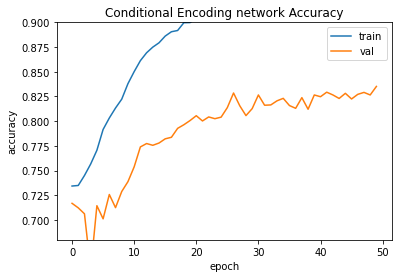

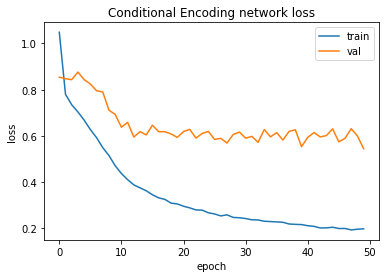

In [51]:
import matplotlib.pyplot as plt
# summarize history for accuracy
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Conditional Encoding network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0.68,0.9])
plt.legend(['train', 'val'], loc='upper right')
fig.set_facecolor('white')
plt.show()
# summarize history for loss
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Conditional Encoding network loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
fig.set_facecolor('white')
plt.show()

In [52]:
model.evaluate([X_test_head, X_test_body], y_test)

795/795 [==============================] - 34s 42ms/step - loss: 0.9845 - acc: 0.7340


[0.9844647645950317, 0.7340337634086609]

In [53]:
# predicting on test set
y_test_pred = model.predict([X_test_head, X_test_body])
pred_test = np.argmax(y_test_pred, axis = 1)
# predicting on train set
y_train_pred = model.predict([X_train_head, X_train_body])
pred_train = np.argmax(y_train_pred, axis = 1)
# predicting on val set
y_val_pred = model.predict([X_val_head, X_val_body])
pred_val = np.argmax(y_val_pred, axis = 1)

In [54]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
print("test accuracy {}".format(accuracy_score(y_true = y_test, y_pred = pred_test)))
print("test F1 score {}".format(f1_score(y_true = y_test, y_pred = pred_test, average='weighted')))

print("train accuracy {}".format(accuracy_score(y_true = y_train, y_pred = pred_train)))
print("train F1 score {}".format(f1_score(y_true = y_train, y_pred = pred_train, average='weighted')))

print("val accuracy {}".format(accuracy_score(y_true = y_val, y_pred = pred_val)))
print("val F1 score {}".format(f1_score(y_true = y_val, y_pred = pred_val, average='weighted')))


test accuracy 0.7340337622476685
test F1 score 0.7240228405220166
train accuracy 0.9527137546468402
train F1 score 0.9467415118305007
val accuracy 0.8351694034504261
val F1 score 0.8359192723693306


In [55]:
!zip -r /content/lstm_cond_final.zip /content/cond_lstm_final

  adding: content/cond_lstm_final/ (stored 0%)
  adding: content/cond_lstm_final/saved_model.pb (deflated 90%)
  adding: content/cond_lstm_final/variables/ (stored 0%)
  adding: content/cond_lstm_final/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/cond_lstm_final/variables/variables.index (deflated 66%)
  adding: content/cond_lstm_final/assets/ (stored 0%)


In [56]:
class unlab_DataSet():
    def __init__(self, name, path="FakeNewsChallenge/fnc-1"):
        self.path = path

        print("Reading test dataset")
        bodies = name+"_bodies.csv"
        stances = name+"_stances_unlabeled.csv"
        print(stances)

        self.stances = self.read(stances)
        articles = self.read(bodies)
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])

        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))
        
    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows

In [57]:
# load file 
competition_test = unlab_DataSet("competition_test")
unlab_h = []
unlab_b = []
for s in competition_test.stances:
  unlab_h.append(s['Headline'])
  unlab_b.append(competition_test.articles[s['Body ID']])
unlab_df = pd.DataFrame(columns= ['head', 'body'])
unlab_df['head'] = unlab_h
unlab_df['body'] = unlab_b
unlab_df.head()

Reading test dataset
competition_test_stances_unlabeled.csv
Total stances: 25413
Total bodies: 904


,head,body
0,Ferguson riots: Pregnant woman loses eye after...,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,An airline passenger headed to Dallas was remo...


In [58]:
clean_head_unlab, clean_body_unlab = data_preprocessing(unlab_h, unlab_b)

25413it [01:14, 342.89it/s]


In [59]:
unlab_df['clean_head'] = clean_head_unlab
unlab_df['clean_body'] = clean_body_unlab

In [60]:
unlab_df.head()

,head,body,clean_head,clean_body
0,Ferguson riots: Pregnant woman loses eye after...,A RESPECTED senior French police officer inves...,ferguson riot pregnant woman loses eye cop bea...,respected senior french police officer investi...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,Dave Morin's social networking company Path is...,crazy conservative sure gitmo detainee killed ...,dave morin s social networking company path re...
2,A Russian Guy Says His Justin Bieber Ringtone ...,A bereaved Afghan mother took revenge on the T...,russian guy say justin bieber ringtone saved b...,bereaved afghan mother took revenge taliban wa...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",Hewlett-Packard is officially splitting in two...,zombie cat buried kitty believed dead meow life,hewlett packard officially splitting following...
4,Argentina's President Adopts Boy to End Werewo...,An airline passenger headed to Dallas was remo...,argentina s president adopts boy end werewolf ...,airline passenger headed dallas wa removed pla...


In [61]:
# texts to sequences for train, validation & test data
X_unlab_head_seq = unlab_df['clean_head'].apply(lambda x: texts_to_sequences([x], word_index))
X_unlab_body_seq = unlab_df['clean_body'].apply(lambda x: texts_to_sequences([x], word_index))

In [62]:
# umnlabeled data
X_unlab_head = pad_sequences(X_unlab_head_seq,maxlen = max_head_len,padding = 'post', truncating= 'post')
X_unlab_body = pad_sequences(X_unlab_body_seq,maxlen = max_body_len,padding = 'post', truncating= 'post')

In [63]:
# predicting labels
y_pred_unlab = model.predict([X_unlab_head, X_unlab_body])
y_labels = np.argmax(y_pred_unlab, axis = 1)

In [64]:
# converting numeric ids to string labels
predicted_stances = []
for i in range(len(y_labels)):
  predicted_stances.append(LABELS[y_labels[i]])

In [65]:
# designing a dataframe
df = pd.read_csv("FakeNewsChallenge/fnc-1/competition_test_stances_unlabeled.csv")
df['Stance'] = predicted_stances

In [66]:
df.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [67]:
# save to answer.csv
df.to_csv('answer.csv', index=False, encoding='utf-8') # From pandas library